## Inclinations with PyStan

I hope you find this useful! This is the notebook we used to infer inclinations for the Pleiades stars in White et al., MNRAS 2017. Please modify this as you see fit for your own use, no need for citation, but please do mention it at least in the acknowledgements. GPL v3 License. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib as mpl
mpl.style.use('seaborn-colorblind') # equality of access is important!

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, display

import pystan

Load the data.

In [3]:
names = ['Alcyone', 'Maia', 'Pleione']

day2sec = 24.*3600.
rsun = 695700

f = np.array([0.4360,0.0967,1.7605])/day2sec
sig_f = np.array([0.0004,0.0008,0.0004])/day2sec
print f
vsini = np.array([149,33,290])
sig_vsini = np.array([8.,5,15.]) # 10% errorbars unless stated otherwise

r = np.array([9.34,6.61,4.17])*rsun
sig_r = np.array([0.72,0.11,0.17])*rsun
print r

N = len(f)

data = dict(mu_f=f,sig_f=sig_f,vsini=vsini, sig_vsini=sig_vsini,mu_r=r,sig_r=sig_r,N=N)

[  5.04629630e-06   1.11921296e-06   2.03761574e-05]
[ 6497838.  4598577.  2901069.]


In [4]:
model_code = """
data {
    int<lower=0> N;           // number of datasets
    
    real<lower=0> mu_f[N];
    real<lower=0> sig_f[N];
    
    real<lower=0> vsini[N];
    real<lower=0> sig_vsini[N];
    
    real<lower=0> mu_r[N];
    real<lower=0> sig_r[N];
}

parameters {
    real<lower=0> f[N];
    real<lower=0> r[N];
    real<lower=0,upper=90> i[N];
}

transformed parameters {
    real cosi[N];
    for (n in 1:N) {
        cosi[n] <- cos(i[n]*pi()/180);
        }
}

model {
    for (n in 1:N) {
        f[n] ~ normal(mu_f[n], sig_f[n]);
        r[n] ~ normal(mu_r[n], sig_r[n]);
        cosi[n] ~ uniform(0,1);
        vsini[n] ~ normal(r[n] * 2 * pi() * f[n] * sin(i[n]*pi()/180), sig_vsini[n]);
        }
}
"""

In [5]:
model = pystan.StanModel(model_code=model_code) 

In [6]:
fit = model.sampling(data=data, iter=10000, chains=4)

In [7]:
results = fit.extract()

In [8]:
mua = (np.mean(results["i"][10000:,:],axis=0), np.std(results["i"][10000:,:],axis=0))


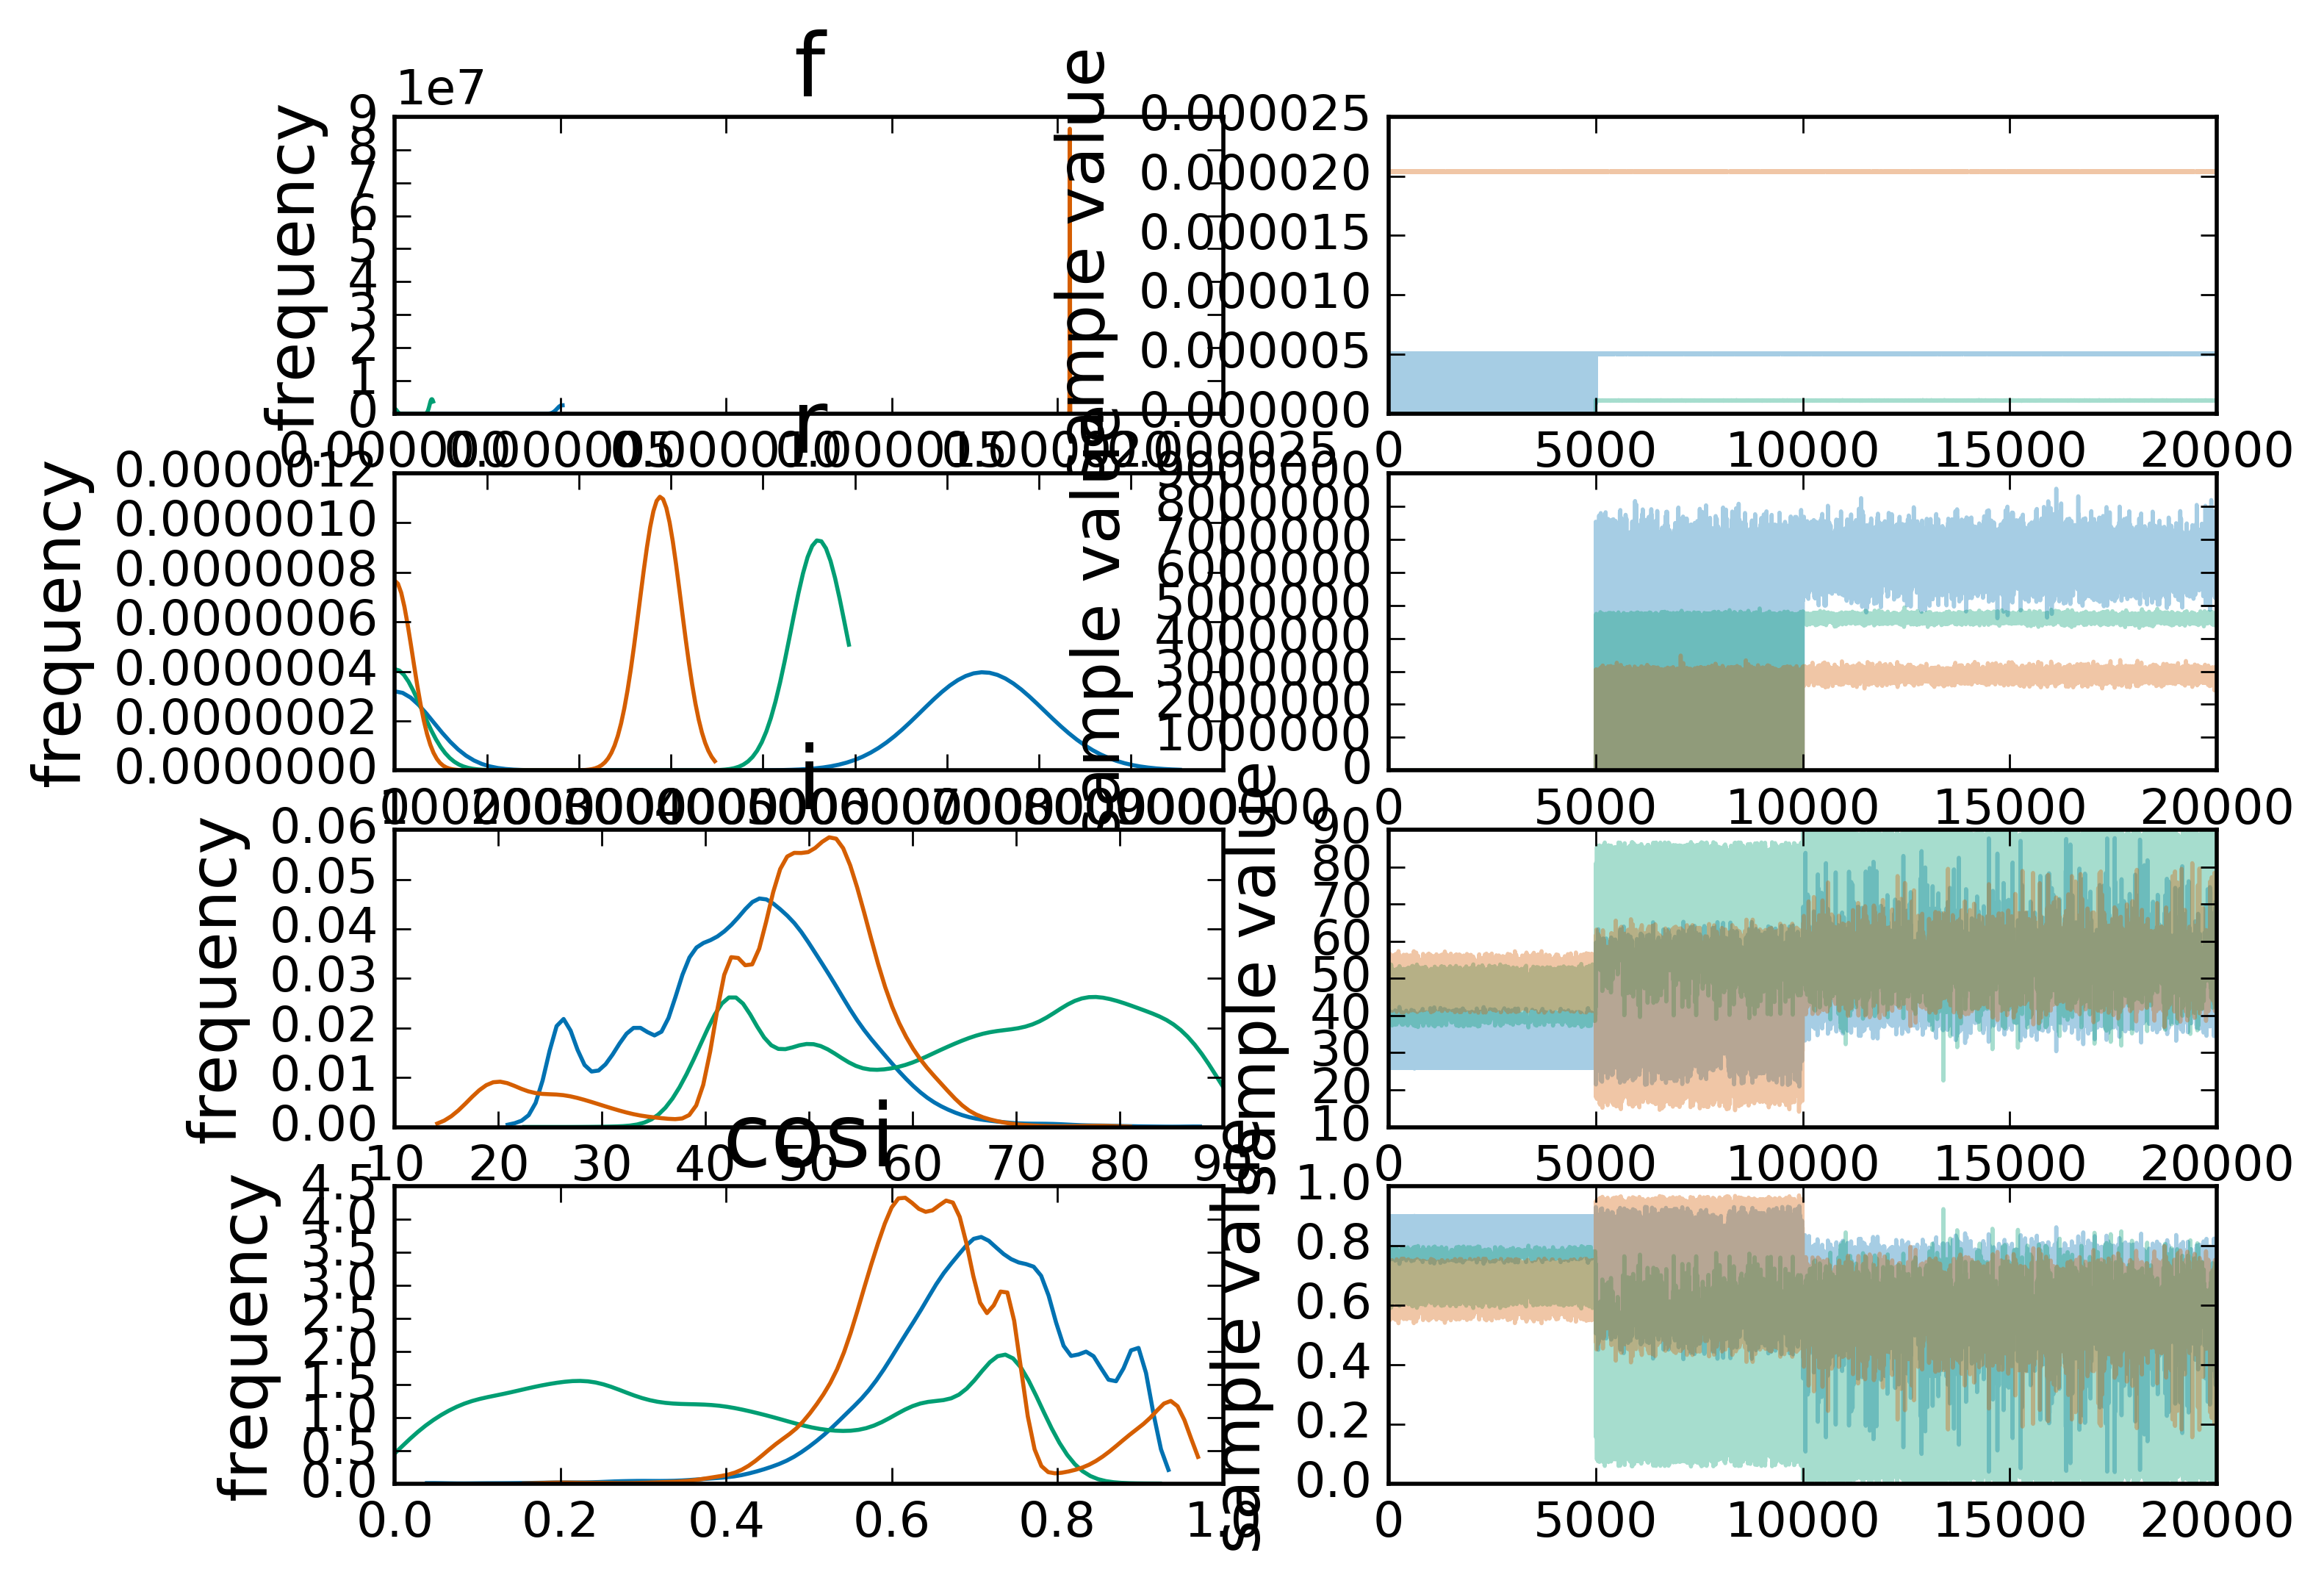

In [9]:
fit.plot();

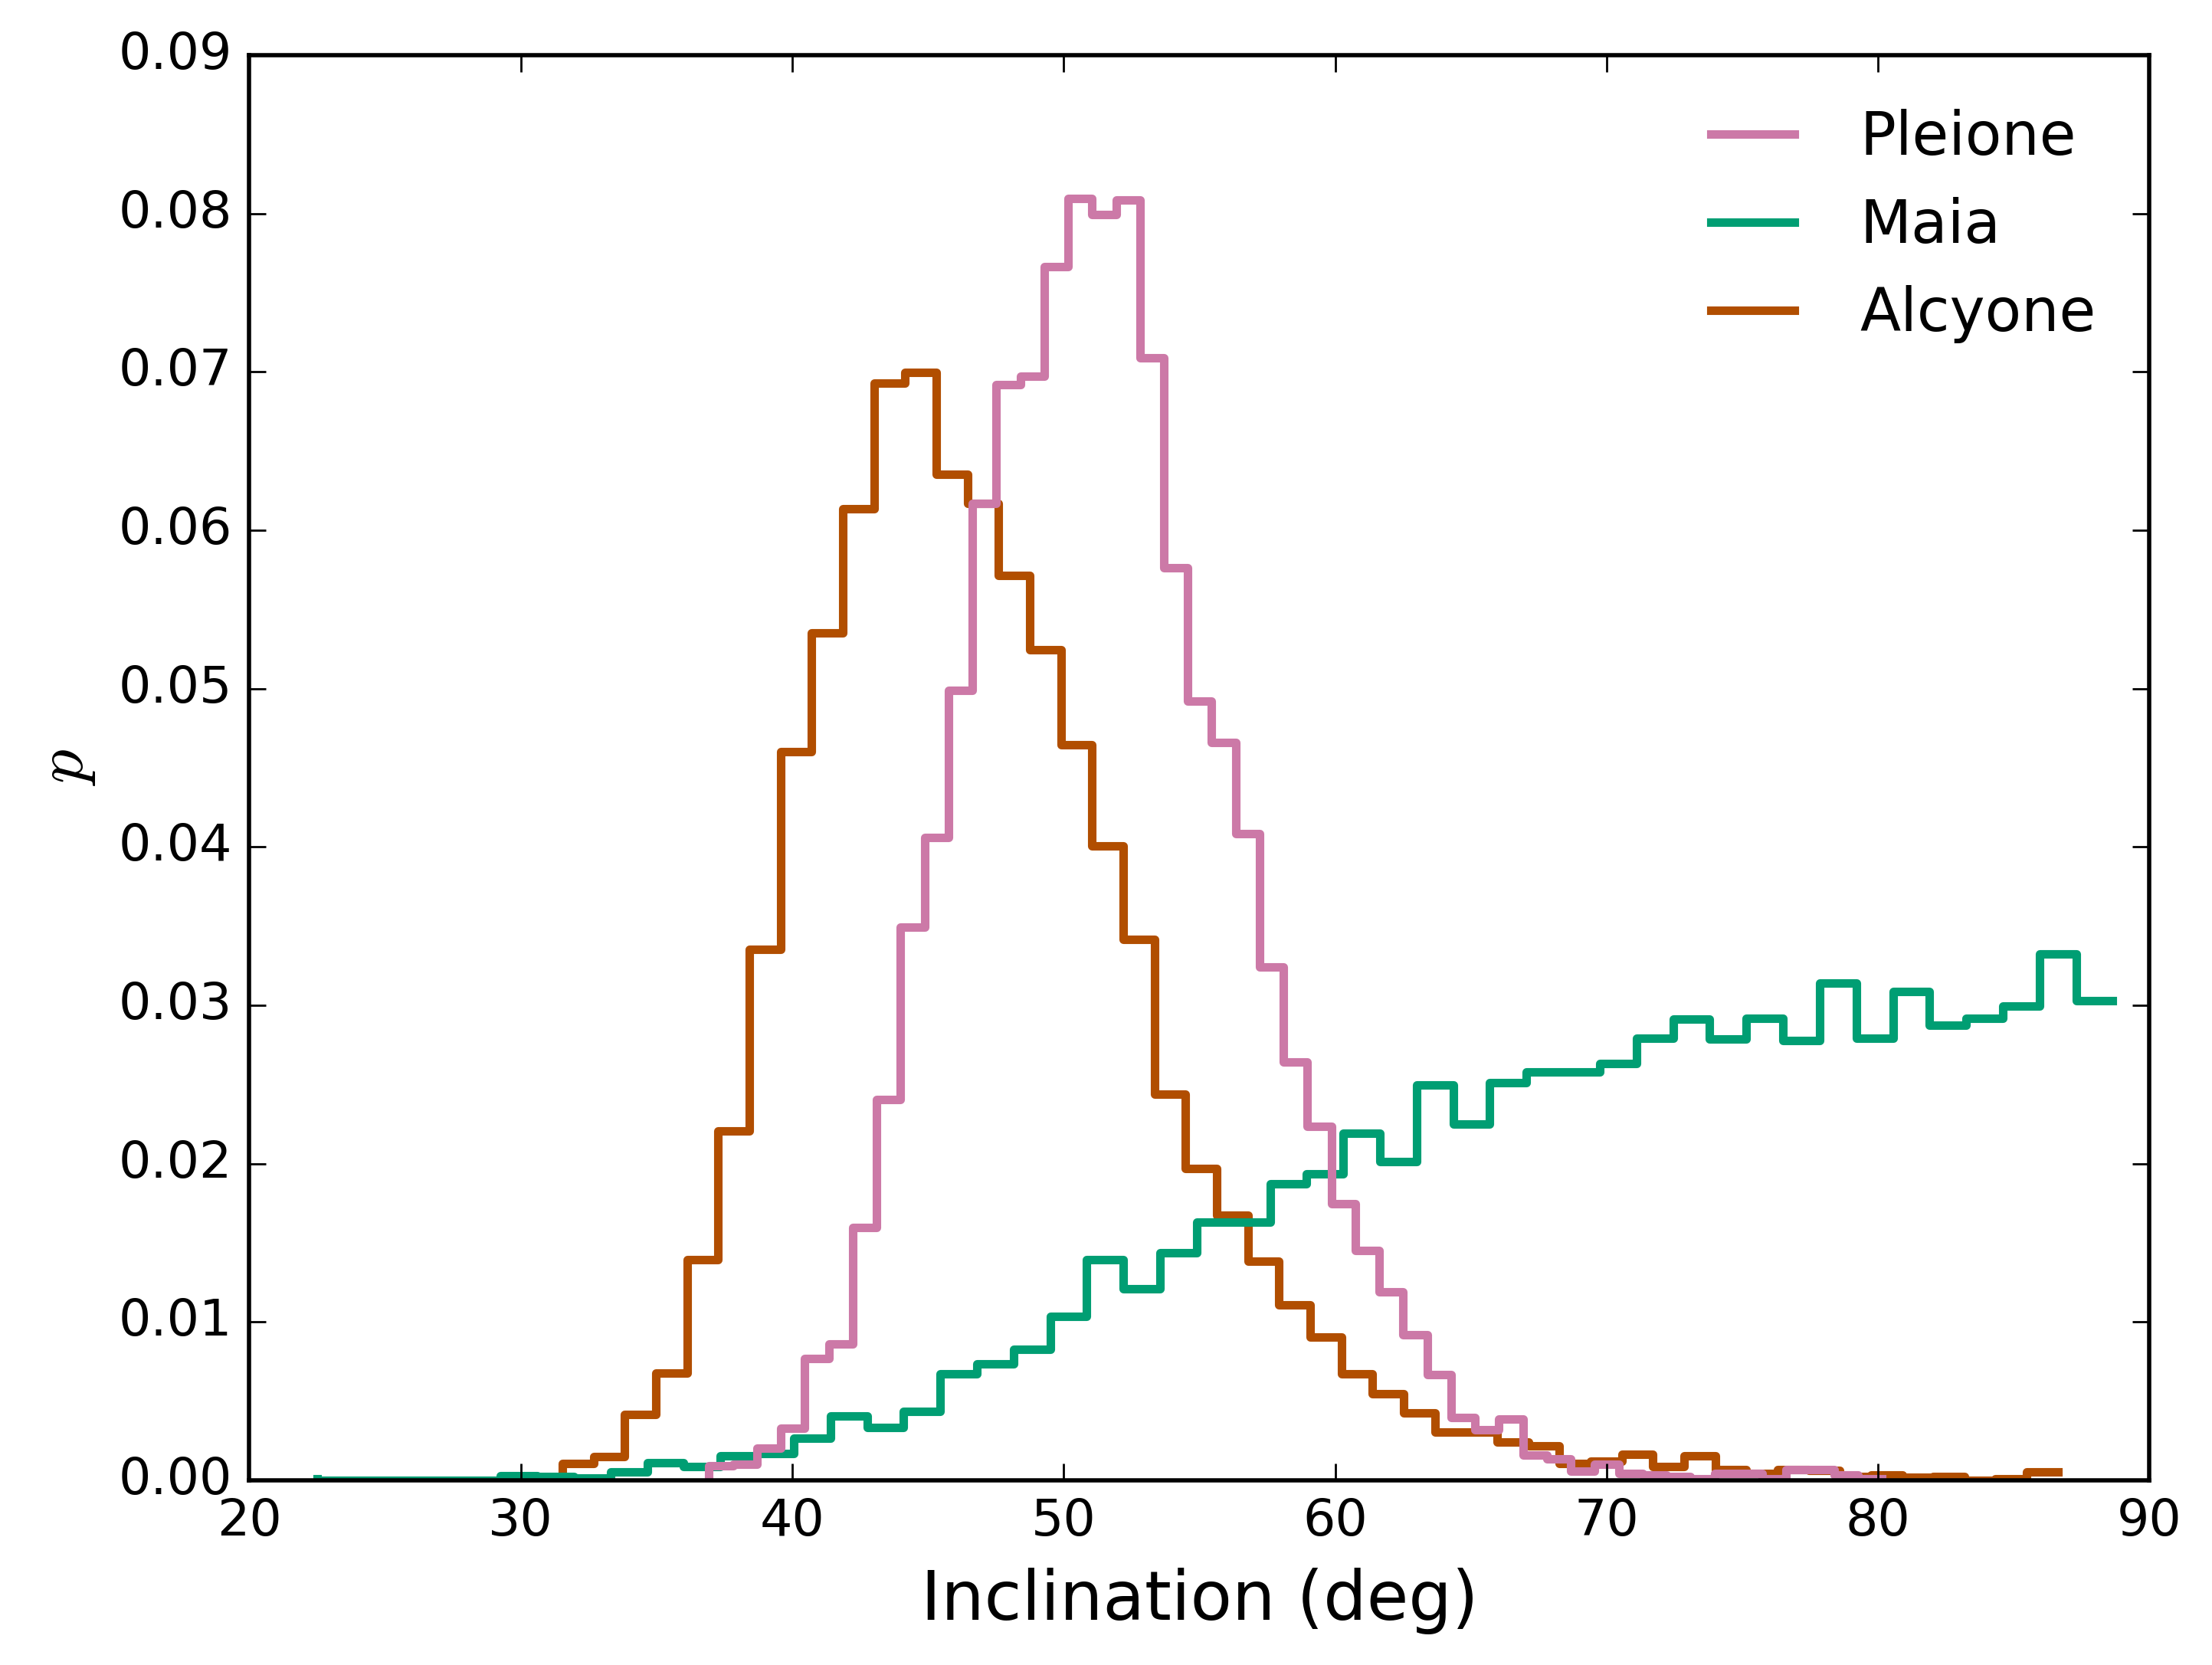

In [15]:
ax = plt.axes()
# change as you see fit
vermilion = ((213.,94.,0.))
vermilion = (213/sum(vermilion),94/sum(vermilion),0)
verm = mpl.colors.rgb2hex(vermilion) # get alcyone colour

colours = mpl.rcParams['axes.color_cycle']

papercolours = [verm,colours[1],colours[3]]

for j in range(3): # this is the real bit that makes the histograms
    vals, bins = np.histogram(results["i"][10000:,j],bins=50,normed=True)
    plt.step(bins[:-1],vals,color=papercolours[j],label=names[j],lw=2)

    handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1],fontsize=14,frameon=False)

plt.xlabel(r'Inclination (deg)')
plt.ylabel(r'$p$')
plt.savefig('pleiades_inclinations.png')
plt.savefig('pleiades_inclinations.eps')

In [13]:
tosave = {names[0]:results['i'][:,0],
          names[1]:results['i'][:,1],
          names[2]:results['i'][:,2]}
print tosave
from astropy.table import Table
stuff = Table(tosave)
stuff.write('pleione_maia_alcyone_incs.csv')

{'Maia': array([ 38.92332973,  40.65512409,  44.44108571, ...,  73.17780958,
        81.40144694,  59.89779397]), 'Pleione': array([ 47.2661988 ,  46.6032428 ,  41.89608135, ...,  53.53764006,
        49.10608747,  54.44998443]), 'Alcyone': array([ 29.73616368,  35.40376483,  28.36654603, ...,  45.55461083,
        41.5144383 ,  55.89899173])}
